The MIT License

Copyright (c) 2019 Veronica Medrano

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.

The following code is a derivative work of the code below that detects politcal sentiment, which is licensed under the MIT License. This code is also licensed under the terms of the MIT License, which can be found [here](https://github.com/vnoelifant/twitter_detect_depression/blob/master/LICENSE). Minor modifications were applied to focus on my problem, which is identify the words/phrases that indicate a mental disorder. Full citation of code is as follows:

+ Source Code Title: FINAL____twitter_sentiment_twitter.ipynb
+ Author: Ronald Wahome
+ Availability: https://github.com/RonKG/Machine-Learning-Projects-2/tree/master/3.%20NLP_twitter_sentiment_analysis


## Introduction
While research has shown that throughout the decades, rates of diagnosing mental illness have improved, many cases remain undetected. Further, I have recently been interested in utilizing machine learning/deep learning tools to address this problem.Therefore in this project I demonstrate the key steps needed in a sentiment analysis problem which predicts whether a tweet is classified to imply someone does have a mental disorder, or someone does not have a mental disorder. For this project, it was decided to repeat an exisiting example of predictions made on sentiment in politics, tweaking some code to cater to my problem.

An initial roadblock included finding a training data set with actual labels of whether someone is depressed or not. This is likely due to ethical concerns for others' privacy. It was time-consuming to find data, and if there was data, the approval process seemed long. Luckily through research in the open-source community, I was able to find publicly available data from Stanford which included pre-generated sentiment labels. While not as accurate, it was good to use for the problem. There was also a debate in how to pull future test data. I was initially concerned with authorization issues in accessing Twitter's API, so looked into Twint, a twitter scraping tool. It was, however difficult to find examples utilizing Twint that worked well at the time, and luckily I had no issues accessing Twitter's API, so went that route. It was also easy to query multiple search terms this way. It was found out later on, that Twint can also search for multiple terms. I think they are both good options for this kind of problem.

Another road block was thinking I wasn't getting enough data from the API, but I figured out what to add in the code to increase the amount necessary for the project.  I also did more of a trial-error method for the query, deciding to include mostly negative terms, and one positive term, to see if the model is able to predict all moods, but in the future, I want to explore if there are better ways in pulling and organizing test data, to see if that may improve the model.  

The research was very involved as I am new to the field of NLP. I utilized articles, read through similar code, and found that the resources below were the best resources to learn from, and build off of. 

Additional Resources: 

https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-one-5ac2d06b63fb (article by the author of the code from above)

https://towardsdatascience.com/the-real-world-as-seen-on-twitter-sentiment-analysis-part-two-3ed2670f927d (article by the author of the code from above)

https://github.com/prateekjoshi565/twitter_sentiment_analysis 

https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/\\ (author of above code)

http://aclweb.org/anthology/W18-0609

https://pdfs.semanticscholar.org/ba53/c6d6acc62f3774874bf7d4cd889276593b88.pdf


The major steps of a text sentiment analysis are as follows and detailed in the code:

+ Tweet preprocessing/cleaning
+ Story Generalization and Visualization from Tweets
+ Extract features from cleaned tweets
+ Model Building: Sentiment Analysis


In [31]:
# import necessary libraries
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
import nltk

from nltk.corpus import stopwords
#nltk.download()
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
#from tweepy import OAuthHandler
import json
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

In [32]:
# load training data containing pre-generated labels ('Sentiment Analysis Dataset 2.csv')
# load train data
data = pd.read_csv('Sentiment Analysis Dataset 2.csv',
                   error_bad_lines=False)
data.columns = ['id','label','source','text']
data.head(5)

b'Skipping line 8836: expected 4 fields, saw 5\n'
b'Skipping line 535882: expected 4 fields, saw 7\n'


,id,label,source,text
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


### Analyze Training Data

In [33]:
# analyze the training data
# get text and matching label columns
data = data.drop(['id','source'],axis=1)
data.head(10)

,label,text
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
5,0,or i just worry too much?
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!
7,0,Sunny Again Work Tomorrow :-| ...
8,1,handed in my uniform today . i miss you ...
9,1,hmmmm.... i wonder how she my number @-)


In [34]:
# check the number of positive vs. negative tagged sentences
positives = data['label'][data.label == 0]
negatives = data['label'][data.label == 1]

print('number of positve tagged sentences is:  {}'.format(len(positives)))
print('number of negative tagged sentences is: {}'.format(len(negatives)))
print('total length of the data is:            {}'.format(data.shape[0]))

number of positve tagged sentences is:  788435
number of negative tagged sentences is: 790177
total length of the data is:            1578612


In [35]:
# get unique label counts
data.groupby('label').describe()

text                                                                
        count  unique                                                top freq
label                                                                        
0      788435  788435  I don't know if anyone will read this! I can't...    1
1      790177  790177  @BornRandy I wish the local kennels thought th...    1

In [36]:
# get a word count per sentence column
def word_count(sentence):
    return len(sentence.split())
    
data['word count'] = data['text'].apply(word_count)
data.head(3)

,label,text,word count
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5


### Visual Story: Training Data 

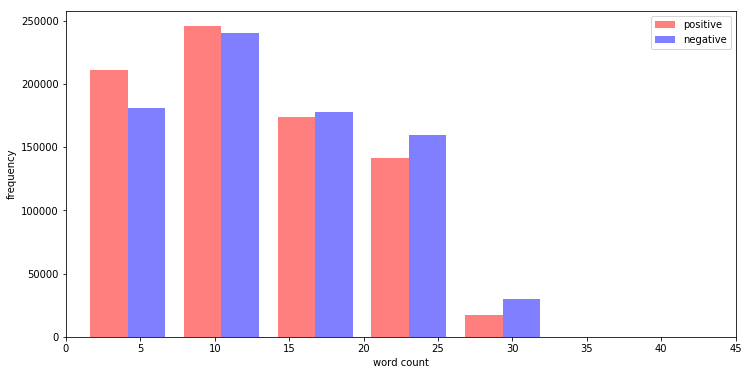

In [37]:
# plot word count distribution for both positive and negative sentiments
x = data['word count'][data.label == 1]
y = data['word count'][data.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

Per above, we have a good training data set due to expected Twitter word cound and equal distribution of positive and negative sentiment. 

In [38]:
# get most common words in training dataset
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('i', 741876),
 ('to', 556149),
 ('the', 516654),
 ('a', 374024),
 ('my', 309966),
 ('and', 294805),
 ('you', 236109),
 ('is', 229444),
 ('for', 212852),
 ('in', 209009)]

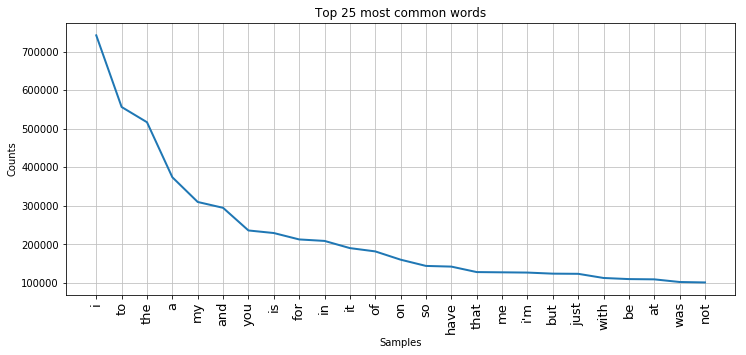

Text(0.5,1,'log-log plot of words frequency')

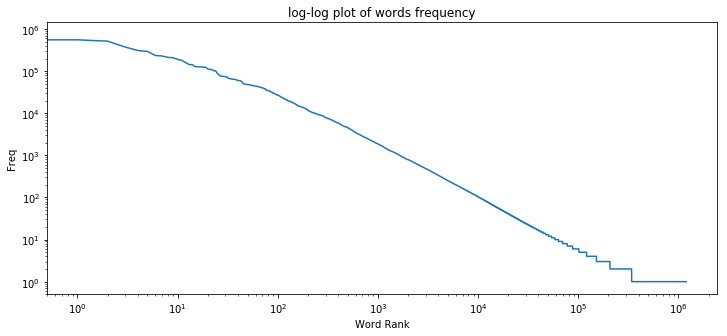

In [39]:
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.title('Top 25 most common words')
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log plot
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")
plt.title('log-log plot of words frequency')

### Access Data from Twitter API
Code commented out for ease in running code multiple times

In [40]:
"""
# download Twitter API data (to be used as the unseen test data later)
# twitter api credentials - you need these to gain access to API

consumer_key = 'yIAGlXwYyXicUqhT0K0Kzfmb9'
consumer_secret = 'B2q22unnpQbBt4rwDu9MqaNjIuuwKUUYHjXfOB9pBmKOfewMoR'
access_token = '1036865354268663808-wLzDbYDMYH2EqcrEAkaao6obkx1qeU'
access_token_secret = '7S0j12WLJl28DVqBZgPXjFXrmEg7Nfref2Sagdf5ohZ2j'

# instantiate the api
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
"""

"\n# download Twitter API data (to be used as the unseen test data later)\n# twitter api credentials - you need these to gain access to API\n\nconsumer_key = 'yIAGlXwYyXicUqhT0K0Kzfmb9'\nconsumer_secret = 'B2q22unnpQbBt4rwDu9MqaNjIuuwKUUYHjXfOB9pBmKOfewMoR'\naccess_token = '1036865354268663808-wLzDbYDMYH2EqcrEAkaao6obkx1qeU'\naccess_token_secret = '7S0j12WLJl28DVqBZgPXjFXrmEg7Nfref2Sagdf5ohZ2j'\n\n# instantiate the api\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_token_secret)\napi = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)\n"

In [41]:
"""
# string to search on twitter
query = 'depressed OR anxiety OR hopeless OR numb OR I am depressed OR I want to die'

# open/create a csv file to append data
csvFile = open('tweet_mental_test_3.csv', 'w',encoding='utf-8')
# use csv Writer
csvWriter = csv.writer(csvFile)

# get data from twitter
tweet_num = 0
for tweet in tweepy.Cursor(api.search,q=query,count=10000000,lang="en").items(5000):
    #print(tweet)

    if tweet.place is not None:
        try:
            # not entirely necessary but you can inspect what is being written to file
            print ('tweet number: {}'.format(tweet_num), tweet.text, tweet.place.full_name)
            # write data to csv
            csvWriter.writerow([tweet.created_at,
                                tweet.user.location,
                                tweet.user.followers_count,
                                tweet.user.friends_count,
                                tweet.text,
                                tweet.place.bounding_box.coordinates,
                                tweet.place.full_name,
                                tweet.place.country,
                                tweet.place.country_code,
                                tweet.place.place_type])
            tweet_num += 1
            
        except Exception:
            pass
"""

'\n# string to search on twitter\nquery = \'depressed OR anxiety OR hopeless OR numb OR I am depressed OR I want to die\'\n\n# open/create a csv file to append data\ncsvFile = open(\'tweet_mental_test_3.csv\', \'w\',encoding=\'utf-8\')\n# use csv Writer\ncsvWriter = csv.writer(csvFile)\n\n# get data from twitter\ntweet_num = 0\nfor tweet in tweepy.Cursor(api.search,q=query,count=10000000,lang="en").items(5000):\n    #print(tweet)\n\n    if tweet.place is not None:\n        try:\n            # not entirely necessary but you can inspect what is being written to file\n            print (\'tweet number: {}\'.format(tweet_num), tweet.text, tweet.place.full_name)\n            # write data to csv\n            csvWriter.writerow([tweet.created_at,\n                                tweet.user.location,\n                                tweet.user.followers_count,\n                                tweet.user.friends_count,\n                                tweet.text,\n                              

### Analyze Test Data and Build a Working DataFrame

In [42]:
# create column names
col_names=['date','user_loc','followers','friends','message','bbox_coords',\
           'full_name','country','country_code','place_type']

# read csv
df_test = pd.read_csv('tweet_mental_test_3.csv', names=col_names)

# check head
df_test.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-12-25 01:17:13,The 1975 by The 1975,539,964,Yes tomorrow is Christmas and yes I am excited...,"[[[-112.074758, 40.630579], [-111.920124, 40.6...","West Valley City, UT",United States,US,city
1,2018-12-24 16:56:32,Somewhere being a gud noodle⭐️,3653,4439,My cousin: “your not going hard enough🙄”\nMe: ...,"[[[-112.3239143, 33.29026], [-111.9254391, 33....","Phoenix, AZ",United States,US,city
2,2018-12-23 17:35:29,"Massachusetts, USA",146,575,@altCourierSix No- not at all. Respectfully.\n...,"[[[-73.508143, 41.187054], [-69.858861, 41.187...","Massachusetts, USA",United States,US,admin
3,2018-12-23 17:16:15,"Plymouth, England",5782,1943,@LukePollard Yep but if you get into power? S...,"[[[-4.0964915, 50.3893936], [-4.030421, 50.389...","Marsh Mills, England",United Kingdom,GB,city
4,2018-12-23 07:15:35,"Marysville, WA",1347,427,as much as my life is completely falling apart...,"[[[-122.220382, 48.0199614], [-122.108673, 48....","Marysville, WA",United States,US,city


In [43]:
# Sort dataframe by date column
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values(by='date',ascending=True)
df_test = df_test.reset_index().drop('index',axis=1)
df_test.head()

,date,user_loc,followers,friends,message,bbox_coords,full_name,country,country_code,place_type
0,2018-12-15 12:34:28,Fantasyland,777,432,Oh how badly I want to put in for an er becaus...,"[[[-87.634643, 24.396308], [-79.974307, 24.396...","Florida, USA",United States,US,admin
1,2018-12-15 12:40:10,"Makati City, National Capital",96,91,with this pain i am feeling right now i want t...,"[[[120.7638121, 14.7575264], [120.8677259, 14....","Malolos City, Central Luzon",Republic of the Philippines,PH,city
2,2018-12-15 12:52:01,"Los Angeles, CA",329,345,I am certain this is not a hill I want to be o...,"[[[-118.668404, 33.704538], [-118.155409, 33.7...","Los Angeles, CA",United States,US,city
3,2018-12-15 14:23:22,"Dublin City, Ireland",1024,339,Sorry there’s videos from last night of me sin...,"[[[-6.4757083, 53.3508617], [-5.9957316, 53.35...","Fingal, Ireland",Ireland,IE,city
4,2018-12-16 01:42:49,"Stony Plain, AB",427,1234,@LoyalcompanyRV @Teresa_keeps @JayBallYeg You ...,"[[[-113.71368, 53.395531], [-113.271555, 53.39...","Edmonton, Alberta",Canada,CA,city


In [44]:
# get central geo location from the bounding box for later mapping

# helper function to get mean of lats and longs
def geo_mean(x):
    y = json.loads(x)
    y = np.asarray(y)
    mean_geoloc = np.add(np.add((y[:][0][0]),(y[:][0][1]))/2,\
                         (np.add((y[:][0][2]),(y[:][0][3]))/2))/2    
    return np.around(mean_geoloc,decimals=6)

# ____________________________________________________________

# append new column  and clean up df
df_test['geo_code'] = df_test['bbox_coords'].apply(geo_mean)
df_test = df_test.drop(['bbox_coords','place_type','followers','friends'],axis=1)
df_test.head()

,date,user_loc,message,full_name,country,country_code,geo_code
0,2018-12-15 12:34:28,Fantasyland,Oh how badly I want to put in for an er becaus...,"Florida, USA",United States,US,"[-83.804475, 27.698682]"
1,2018-12-15 12:40:10,"Makati City, National Capital",with this pain i am feeling right now i want t...,"Malolos City, Central Luzon",Republic of the Philippines,PH,"[120.815769, 14.824525]"
2,2018-12-15 12:52:01,"Los Angeles, CA",I am certain this is not a hill I want to be o...,"Los Angeles, CA",United States,US,"[-118.411906, 34.02079]"
3,2018-12-15 14:23:22,"Dublin City, Ireland",Sorry there’s videos from last night of me sin...,"Fingal, Ireland",Ireland,IE,"[-6.23572, 53.494598]"
4,2018-12-16 01:42:49,"Stony Plain, AB",@LoyalcompanyRV @Teresa_keeps @JayBallYeg You ...,"Edmonton, Alberta",Canada,CA,"[-113.492618, 53.55582]"


In [45]:
df_test.to_pickle('df_ment3.p') # save dframe to pickle

In [46]:
df_ment = pd.read_pickle('df_ment3.p')  # load from pickle
print(df_ment)

                  date                        user_loc  \
0  2018-12-15 12:34:28                     Fantasyland   
1  2018-12-15 12:40:10  Makati City, National Capital    
2  2018-12-15 12:52:01                 Los Angeles, CA   
3  2018-12-15 14:23:22            Dublin City, Ireland   
4  2018-12-16 01:42:49                 Stony Plain, AB   
5  2018-12-16 01:56:21                     Houston, TX   
6  2018-12-16 04:21:24               Manilaaaaaaaaaaaa   
7  2018-12-16 13:13:51              madison heights va   
8  2018-12-16 21:10:38                             NaN   
9  2018-12-17 06:56:20                           Yukon   
10 2018-12-17 07:12:37                             NaN   
11 2018-12-17 19:03:22         Buenos Aires, Argentina   
12 2018-12-17 21:02:05                     Chicago, IL   
13 2018-12-17 22:09:17                    Savannah, GA   
14 2018-12-18 03:57:16            Leeds, Yorkshire, UK   
15 2018-12-18 04:53:13                 Atlanta, GA USA   
16 2018-12-18 

### Tweets Preprocessing and Cleaning

In [47]:
# pre-process/clean tweets

# remove unwanted characters, remove stop words
# tokenize (split all the sentences in the dataset to get individual words (tokens) 

# Plan to update in the future

# use nltk PorterStemmer() for stemming (for future, consider)

# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________

# clean dataframe's text column
df_ment['message'] = df_ment['message'].apply(processTweet)
# preview some cleaned tweets
df_ment['message'].head()

0    how badly want put for because hungover want d...
1            with this pain feeling right now want die
2    certain this not hill want much less die color...
3    sorry there’ videos from last night singing lu...
4    you may not believe but glad that you guys did...
Name: message, dtype: object

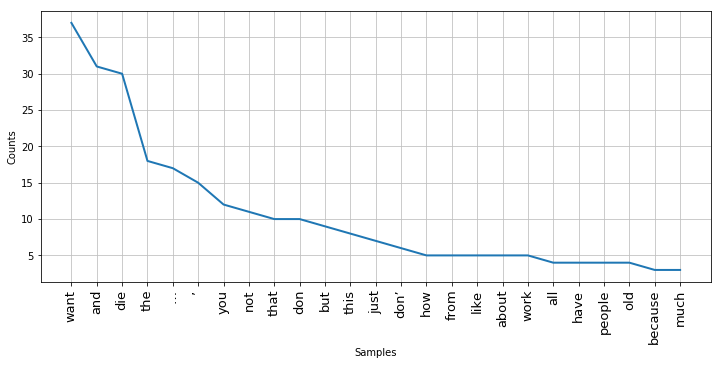

Text(0.5,0,'Word Rank')

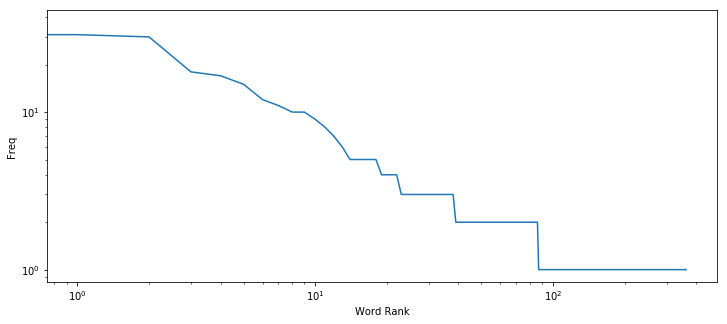

In [48]:
# most common words in twitter dataset
all_words = []
for line in list(df_ment['message']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())

# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)

plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")

In [49]:
# drop duplicates
df_ment = df_ment.drop_duplicates('message')
df_ment.shape

(50, 7)

### An important update to the code is including first person singular pronouns in stop-word list because it was researched that these terms are commonly used by those diagnosed with mental disorders. 

In [50]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# show stop words examples
stop_words = stopwords.words('english') # Show some stop words
' , '.join(stop_words)[:200], len(stop_words)
print(type(stop_words))
#print(stop_words)
#remove common first person sinfular pronouns from stop word list (they are important for detecting mental disorders)
firstPronouns = ['i','my','me','myself']
for pro in firstPronouns:
    stop_words.remove(pro)
print(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vnoelifant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<class 'list'>
['we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'a

#### A common step in text-processing is tokenizing, to convert text into words stored in a list

In [51]:
# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords except for those in first person
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


#def remove_words(word_list):
    #remove = ['depressed','anxiety','excited','hopeless','numb','...','“','”','’','…']
    #return [w for w in word_list if w not in remove]

# -------------------------------------------

# tokenize message column and create a column for tokens
df_ment = df_ment.copy()
df_ment['tokens'] = df_ment['message'].apply(text_process) # tokenize style 1
#df_test['no_pauls'] = df_test['tokens'].apply(remove_words) #tokenize style 2
df_ment.head()

,date,user_loc,message,full_name,country,country_code,geo_code,tokens
0,2018-12-15 12:34:28,Fantasyland,how badly want put for because hungover want d...,"Florida, USA",United States,US,"[-83.804475, 27.698682]","[badly, want, put, hungover, want, die, financ..."
1,2018-12-15 12:40:10,"Makati City, National Capital",with this pain feeling right now want die,"Malolos City, Central Luzon",Republic of the Philippines,PH,"[120.815769, 14.824525]","[pain, feeling, right, want, die]"
2,2018-12-15 12:52:01,"Los Angeles, CA",certain this not hill want much less die color...,"Los Angeles, CA",United States,US,"[-118.411906, 34.02079]","[certain, hill, want, much, less, die, coloriz..."
3,2018-12-15 14:23:22,"Dublin City, Ireland",sorry there’ videos from last night singing lu...,"Fingal, Ireland",Ireland,IE,"[-6.23572, 53.494598]","[sorry, there’, videos, last, night, singing, ..."
4,2018-12-16 01:42:49,"Stony Plain, AB",you may not believe but glad that you guys did...,"Edmonton, Alberta",Canada,CA,"[-113.492618, 53.55582]","[may, believe, glad, guys, ton, stu…]"


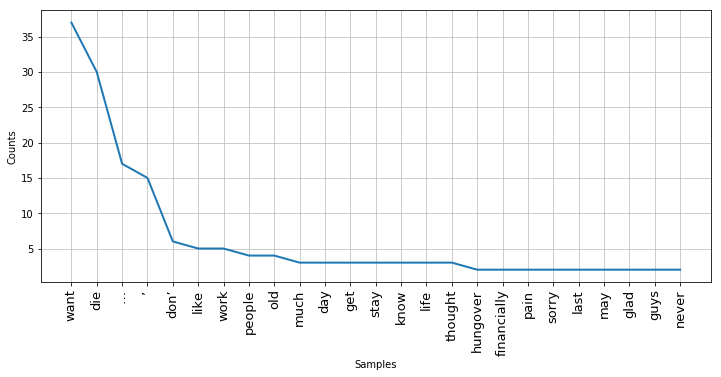

Text(0.5,0,'Word Rank')

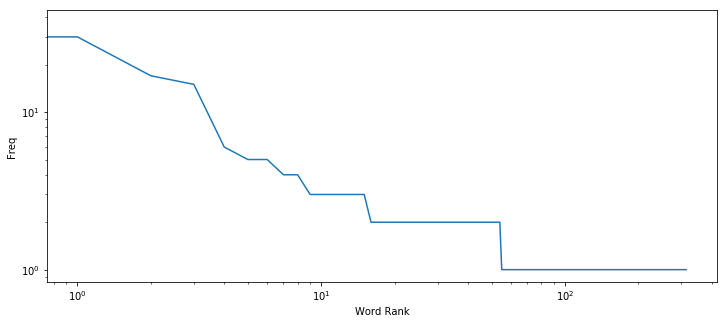

In [52]:
# most common words in twitter dataset after tokenizing
all_words = []
for ls in df_ment['tokens']:
    words = [w for w in ls]
    for word in words:
        all_words.append(word.lower())
    
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

# log-log  of all words 
word_counts = sorted(Counter(all_words).values(), reverse=True)
plt.figure(figsize=(12,5))
plt.loglog(word_counts, linestyle='-', linewidth=1.5)
plt.ylabel("Freq")
plt.xlabel("Word Rank")



### Visual Story: Test Data

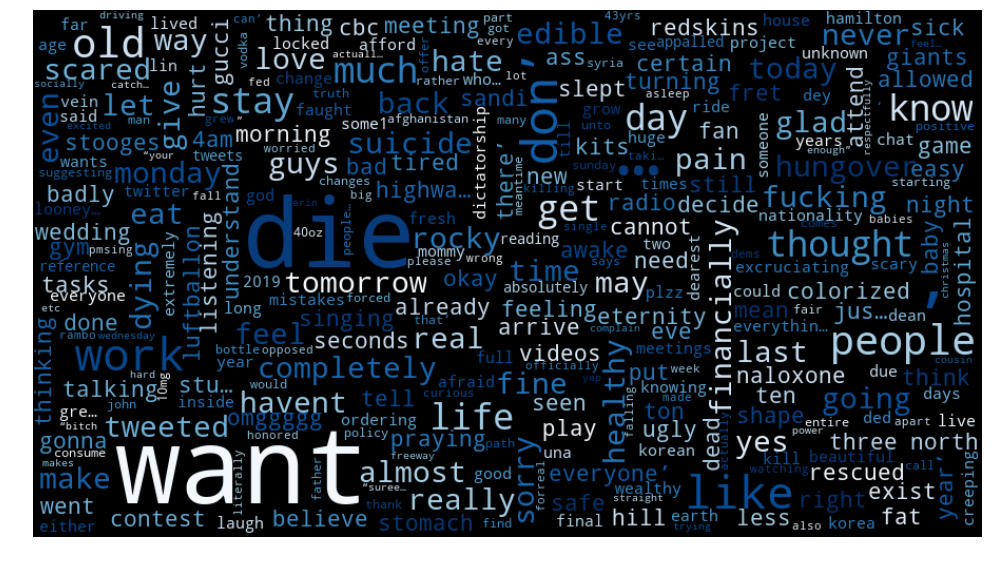

In [53]:
# visualize cleaned tweets/story-telling of data
# graphs, wordclouds
# split sentences to get individual words
all_words = []
for line in df_ment['tokens']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)

# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Extract Features from Cleaned Tweets

#### Bag-of-Words
The raw frequencies of occurrence of a token in a given document: very common in text processing

In [54]:
# extract features from cleaned tweets

# convert each message which is represented by a list
# of tokens into a vector that a machine learning model can understand

# use Bag of Words, TF-IDF, word2vec

# Bag of Words (count of words per document)
# vetorize
bow_transformer = CountVectorizer(analyzer=text_process).fit(df_ment['message'])
# print total number of vocab words
print(len(bow_transformer.vocabulary_))

# transform the entire DataFrame of messages
messages_bow = bow_transformer.transform(df_ment['message'])

# check out the bag-of-words counts for the entire corpus as a large sparse matrix
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

#bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000)
#bow = bow_vectorizer.fit_transform(df_test['tokens'])
#bow.shape

315
Shape of Sparse Matrix:  (50, 315)
Amount of Non-Zero occurences:  461


In [55]:
# example of vectorized text
sample_tweet = df_ment['message'][3]
print(sample_tweet)
print('\n')
# vector representation
bow_sample = bow_transformer.transform([sample_tweet])
print(bow_sample)
print('\n')

sorry there’ videos from last night singing luftballon like just want die who think 


  (0, 62)	1
  (0, 150)	1
  (0, 155)	1
  (0, 166)	1
  (0, 187)	1
  (0, 235)	1
  (0, 241)	1
  (0, 261)	1
  (0, 263)	1
  (0, 287)	1
  (0, 289)	1




#### TF-IDF 
The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are thus less informative than features that occur in a small fraction of the training corpus

In [56]:
# TF-IDF (less emphasis on commonly used words across corpus of data)
# from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf_sample = tfidf_transformer.transform(bow_sample)
print(tfidf_sample)
tfidf_sample.shape

# another way
#tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000)

  (0, 289)	0.11666974321755323
  (0, 287)	0.3445407234108153
  (0, 263)	0.3445407234108153
  (0, 261)	0.3445407234108153
  (0, 241)	0.31158251645031865
  (0, 235)	0.3445407234108153
  (0, 187)	0.3445407234108153
  (0, 166)	0.3445407234108153
  (0, 155)	0.25524008950865146
  (0, 150)	0.31158251645031865
  (0, 62)	0.12175170667983283


(1, 315)

In [57]:
# some IDF (inverse document frequency) example
#print(tfidf_transformer.idf_[bow_transformer.vocabulary_['anxiety']])
#print(tfidf_transformer.idf_[bow_transformer.vocabulary_['depressed']])

In [58]:
# to transform the entire bag-of-words corpus
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(50, 315)


### Updated code to explore word2Vec which is a more advanced feature extraction method to look at the surrounding words in text to generalize what words mean

In [59]:
# word2vec
model_w2v = gensim.models.Word2Vec(
            df_ment['tokens'],
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(df_ment['tokens'], total_examples= len(df_ment['tokens']), epochs=20)

(1160, 9640)

In [60]:
# Let's play around with word2vec to check word similarity
#model_w2v.wv.most_similar(positive="depressed")

### Model Building

The following are the major steps for model building:

+ Do a train/test split on the training dataset 'Sentiment Analysis Dataset 2.csv'
+ Run features and models/classifiers through SciKit Learn Pipeline

  + Models to try are as follows:Logistic Regression, Naive Bayes, Support Vector Machine, RandomForest, XGBoost

+ optimize models using Grid Search and pipeline 
+ get performance metrics
+ make predictions using data downloaded from Twitter API
+ analyze results

#### Testing the NB classifier, which assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. While not as accurate as other models, it is simple to understand and fast, and a good starter candidate for this project

In [61]:
# Run Train Data Through Pipeline analyzer=text_process
X_train, X_test, y_train, y_test = train_test_split(data['text'][:5000], data['label'][:5000], test_size=0.2)


# create pipeline (using model Naive Bayes for this problem, explore others in future)
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

# this is where we define the values for GridSearchCV to iterate over
parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }

# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)

# summarize results
print("\nBest Model: %f using %s" % (grid.best_score_, grid.best_params_))
print('\n')
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
params = grid.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Mean: %f Stdev:(%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Best Model: 0.769000 using {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}


Mean: 0.756000 Stdev:(0.017679) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.765250 Stdev:(0.016473) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.751750 Stdev:(0.018729) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.757000 Stdev:(0.016466) with: {'bow__ngram_range': (1, 1), 'classifier__alpha': 0.001, 'tfidf__use_idf': False}
Mean: 0.762750 Stdev:(0.012958) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': True}
Mean: 0.769000 Stdev:(0.015825) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.01, 'tfidf__use_idf': False}
Mean: 0.757500 Stdev:(0.014100) with: {'bow__ngram_range': (1, 2), 'classifier__alpha': 0.001, 'tfidf__use_idf': True}
Mean: 0.763500 Stdev:(0.014463) with: {'bow__ngram_range'

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    9.8s finished


In [62]:
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [63]:
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_preds))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds))
print('\n')
print(classification_report(y_test, y_preds))

accuracy score:  0.741


confusion matrix: 
 [[642  74]
 [185  99]]


              precision    recall  f1-score   support

           0       0.78      0.90      0.83       716
           1       0.57      0.35      0.43       284

   micro avg       0.74      0.74      0.74      1000
   macro avg       0.67      0.62      0.63      1000
weighted avg       0.72      0.74      0.72      1000



In [64]:
# run predictions on twitter API data
tweet_preds = model_NB.predict(df_test['message'])

# append predictions to dataframe
df_tweet_preds = df_test.copy()
df_tweet_preds['predictions'] = tweet_preds
df_tweet_preds.shape

(50, 8)

In [65]:
# print text and sentiment

index = random.sample(range(tweet_preds.shape[0]), 20)
for text, sentiment in zip(df_tweet_preds.message[index],
                           df_tweet_preds.predictions[index]):
    print (sentiment, '--', text, '\n')

0 -- I'm listening to from here to eternity, and thinking about my last stay in hospital. I am fine as of now, and I do… https://t.co/G35rKnAV4N 

0 -- My cousin: “your not going hard enough🙄”
Me: “bitch I am driving on the freeway do you want to die?!”
Her: “suree… https://t.co/uPKkKwvwRj 

0 -- my Gucci baby @ like 5 am and I want to die (,: https://t.co/LrRrGqjdZi 

0 -- @trollarchjake @DwayneW67065573 @LaughingManPro @want2brd @drakeb871 @davidhogg111 It won't be *me* doing it.

I am… https://t.co/4ZL5TVwKSD 

0 -- But don't fret. I don't need to be rescued. I am completely safe. I don't want to die. I just don't want to exist. 

0 -- People on twitter: i want to die, someone plzz kill me, i am ded inside. 
In real life: i want a long and healthy l… https://t.co/dSNNaf6eAi 

0 -- Back at the gym and let me tell you, I want to die from how out of shape I am 🙃 

0 -- Oh how badly I want to put in for an er because I am so hungover I want to die but I financially cannot do that to mys

### Conclusions
We can see that we have while not a very high accuracy score, the score is not bad, and it's convincing to say we have a good, working algorithm for detecting whether tweets are prone to having a mental disorder. The prediction results are a bit mixed, but at least we do see expected results.  However improvements should be explored in the future to enhance the predictions. With the researched machine learning tools, and available models, I believe this project is a great example to build upon further. 


### Next steps: 
Use more models, such as LSTM CNN to see if the prediction is more accurate, find improved datasets, such as finding those with true labels of mental disorders,figure out alternate ways in pulling test data that may improve the detection (I likely need much more data), predict the actual mental disorder, enhance text/feature exraction, use more labels, such as neutral sentiment labels, explore emojis, research how supportive chat bots can be integrated during real time detection, perhaps with Twitter's Streaming API. 
    